# Image Caption Tutorial

In [193]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import spacy
import string
import re
from spacy.symbols import ORTH
from collections import Counter
import torch.nn.functional as F

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

Image Caption is the task to automatically describe the content of an image. This tutorial explains the Neural Image Caption model from [Vinyals et all 2015](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vinyals_Show_and_Tell_2015_CVPR_paper.pdf). In this model a pre-trained CNN is used as an image encoder. A linear layer is used to connect the CNN output to the input to an RNN that
generates the output sentence. (See figure below)

This tutorial is based on the code from [here](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning). 

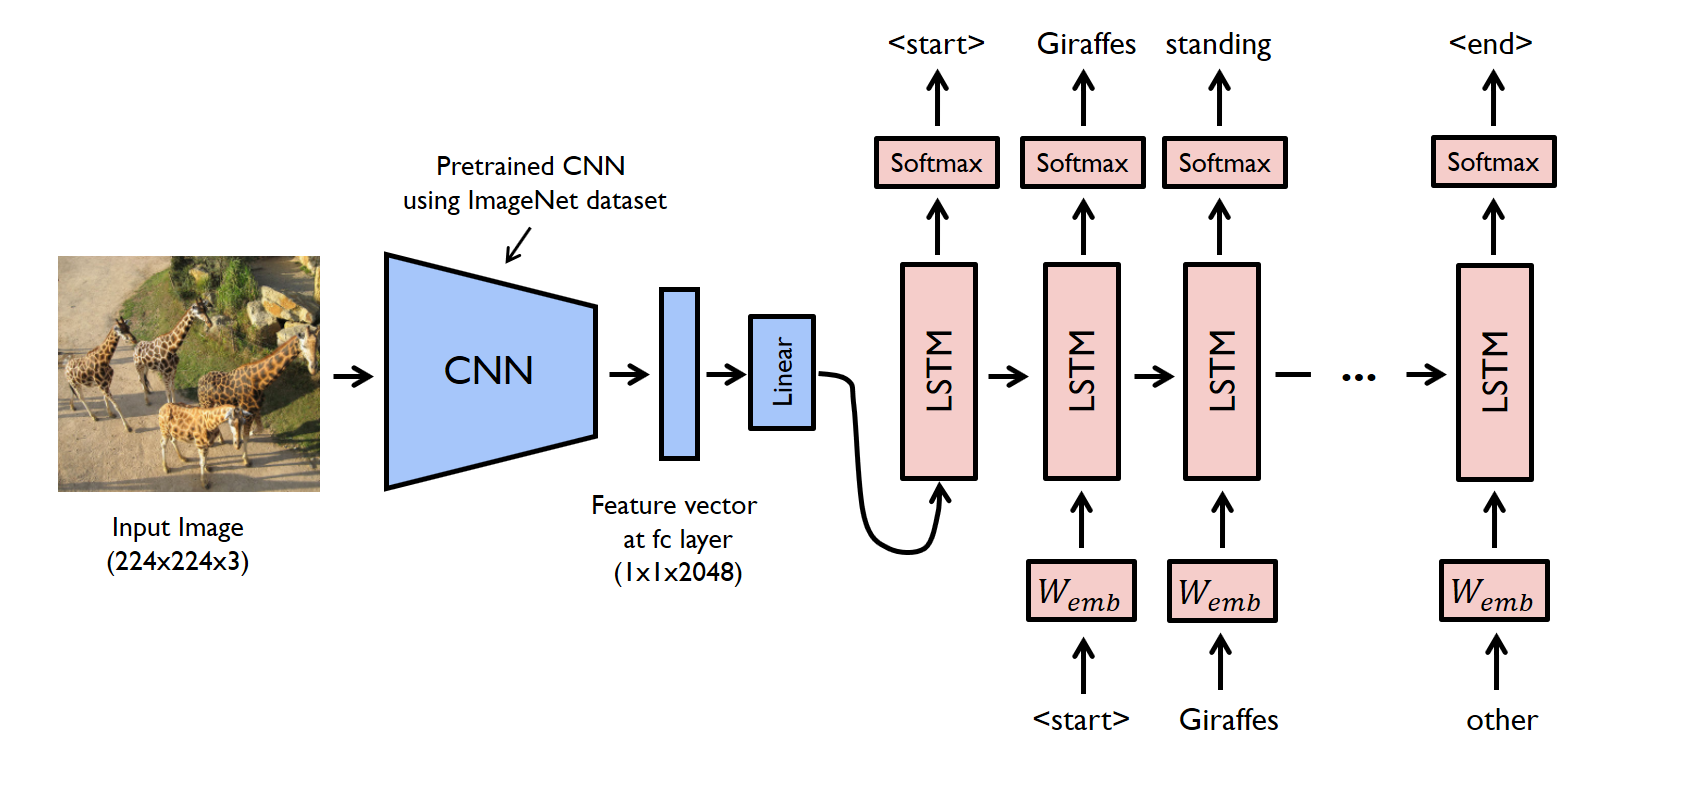

In [3]:
from IPython.display import Image
Image("imgs/image_captioning.png")
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

## Getting the data

```
mkdir coco
wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./coco/ 
wget http://images.cocodataset.org/zips/train2014.zip -P ./coco/ 
wget http://images.cocodataset.org/zips/val2014.zip -P ./coco/
```

## Data 

In [4]:
# for this you need to install COCO api follow directions here: http://cocodataset.org/#download
from pycocotools.coco import COCO
import json

In [5]:
PATH = Path("/data2/yinterian/coco")
train_ann = PATH/"annotations/captions_train2014.json"

In [6]:
# loads captions
coco=COCO(train_ann)
coco

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [7]:
# all training image ids
train_ids = coco.getImgIds()
train_ids[:10]

[57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570]

In [8]:
img_id = train_ids[31]
# get annotation ids for an image
annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)
print(train_ids[0])
anns

57870


[{'image_id': 356702,
  'id': 190242,
  'caption': "A couple of young men sitting in front of a child's laptop."},
 {'image_id': 356702,
  'id': 203397,
  'caption': 'A pair of men looking at a tablet perched on a table.'},
 {'image_id': 356702,
  'id': 205257,
  'caption': 'Two men laugh as they look at a computer.'},
 {'image_id': 356702,
  'id': 205911,
  'caption': 'Two men are smiling looking at a laptop computer.'},
 {'image_id': 356702,
  'id': 210765,
  'caption': 'Two men happily working on a plastic computer'}]

In [9]:
file = coco.loadImgs(img_id)[0]['file_name']
file

'COCO_train2014_000000356702.jpg'

In [10]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

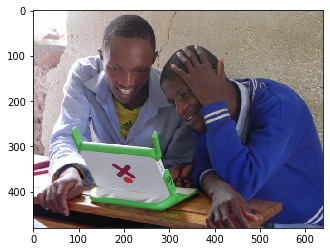

In [11]:
path = PATH/"train2014"/file
im = read_image(path)
plt.imshow(im)

## Data augmentation
Data augmentation is the most important way to avoid overfitting for computer vision tasks.

In [12]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

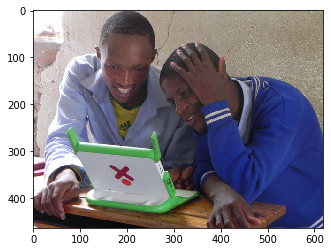

In [13]:
# center crop
im_crop = center_crop(im)
plt.imshow(im_crop)

In [14]:
print(im.shape)

(480, 640, 3)


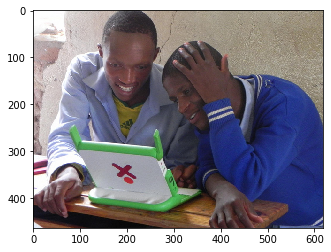

In [16]:
# random crop
im_rand_crop = random_crop(im)
plt.imshow(im_rand_crop)

5.688538941801104


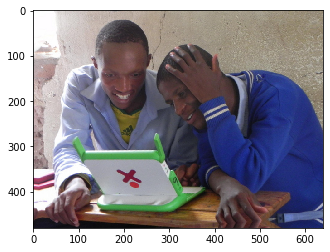

In [17]:
# Random Rotation (-10, 10)
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

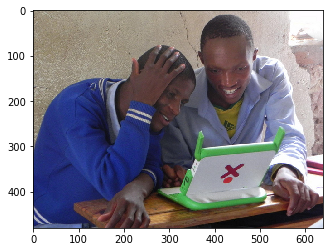

In [18]:
# Horizontal flip
im_f = np.fliplr(im)
plt.imshow(im_f)

## Resizing images
Images should be resized in advanced to speed up training.

In [19]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# resize and center crop
def resize_crop_image(path, sz=(250, 250)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

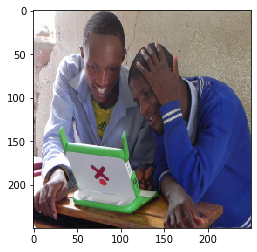

In [20]:
path = PATH/"train2014/COCO_train2014_000000356702.jpg"
im = resize_crop_image(path)
plt.imshow(im)

In [21]:
def resize_all_images(resize_path, org_path):
    files = [x for x in list(org_path.iterdir()) if x.suffix == ".jpg"]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [22]:
resize_train = PATH/"train_resized"
resize_train.mkdir(exist_ok=True)
resize_val = PATH/"val_resized"
resize_val.mkdir(exist_ok=True)

In [23]:
#resize_all_images(resize_train, PATH/"train2014")

In [24]:
#resize_all_images(resize_val, PATH/"val2014")

## Building a vocabulary
Here we build a vocab and save it.

In [25]:
import pickle

### Tokenization with spacy

In [26]:
# tokenization
# first time run this
#!python3 -m spacy download en

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(x)]

In [27]:
coco = COCO(PATH/"annotations/captions_train2014.json")
annIds = list(coco.anns.keys())
caption = coco.anns[annIds[0]]['caption']
print(caption)
spacy_tok(caption.lower())

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
A very clean and well decorated empty bathroom


['a', 'very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom']

### Compute vocab2index

In [28]:
# counts per word
# some more cleaning should be done here
counts = Counter()
for cap_id in annIds:
    caption = coco.anns[cap_id]['caption']
    counts.update(spacy_tok(caption.lower()))

In [29]:
len(counts.keys())

23476

In [30]:
# delete words with little counts
for word in list(counts):
    if counts[word] < 5:
        del counts[word]

In [31]:
len(counts.keys())

8787

In [32]:
vocab2index = {"":0, "UNK":1, "<start>":2, "<end>": 3}
words = ["", "UNK", "<start>", "<end>"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [33]:
with open(PATH/'vocab2index.pickle', 'wb') as handle:
    pickle.dump(vocab2index, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Enconde sequences

In [34]:
def encode_sentence(caption, vocab2index):
    x = spacy_tok(str(caption).lower())
    x = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in x])
    x = np.concatenate(([vocab2index["<start>"]], x, [ vocab2index["<end>"]]))
    return x

In [35]:
cap_id = annIds[0]
caption = coco.anns[cap_id]['caption']
print(caption)
encode_sentence(caption, vocab2index)

A very clean and well decorated empty bathroom


array([ 2,  4,  5,  6,  7,  8,  9, 10, 11,  3])

## Dataset

In [45]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import cv2

def apply_transforms(x):
    """ Applies a random crop, rotation and flip"""
    rdeg = (np.random.random()-.50)*20
    x = rotate_cv(x, rdeg)
    if np.random.random() > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x)
    return x

imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

def normalize(im, stats=imagenet_stats):
    """Normalizes images with Imagenet stats."""
    return (im - stats[0])/stats[1]


def get_caption(coco, vocab, ann_id):
    caption = coco.anns[ann_id]['caption']
    return encode_sentence(caption, vocab)
    

class CocoDataset(Dataset):
    def __init__(self, path, json, vocab, transform=True, sz=250):
        self.path = path
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        self.sz = sz
        # saves time to do this in advance
        self.captions = [get_caption(self.coco, vocab,  ann_id) for ann_id in self.ids]
        
    def __getitem__(self, index):
        ann_id = self.ids[index]
        img_id = self.coco.anns[ann_id]['image_id']
        filename = self.coco.loadImgs(img_id)[0]['file_name']
        x = read_image(self.path/filename)/255
        if self.transform:
            x = apply_transforms(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, self.captions[index]
        
    def __len__(self):
        return len(self.ids)

In [46]:
with open(PATH/'vocab2index.pickle', 'rb') as handle:
    vocab = pickle.load(handle)

In [47]:
len(vocab.keys())

8791

In [48]:
! ls $PATH/"annotations"

captions_train2014.json  captions_val2014.json


In [49]:
train_ds = CocoDataset(PATH/"train_resized", PATH/"annotations/captions_train2014.json", vocab)
valid_ds = CocoDataset(PATH/"val_resized", PATH/"annotations/captions_val2014.json", vocab,
                    transform=False )

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [50]:
x, y = valid_ds[20]
print(x.shape)
print(y)

(3, 234, 234)
[   2    4   11   60    7 1058  641 1694  745   19    3]


In [51]:
print(len(train_ds), len(valid_ds)) # 40k valid images

414113 202654


## Data loader
This is how to do a data loader that allows for variable length captions.

### `collate_fn` function

In [53]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    Custom collate_fn for variable length padding. 
    Args:
        data: list of tuple (image, caption). 
            - image: numpy array of shape (3, 250, 250).
            - caption: list of word indexes of variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 250, 250).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = np.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.Tensor(cap[:end])        
    return torch.FloatTensor(images), targets, lengths

In [81]:
trn_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(valid_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [82]:
x, y, lengths = next(iter(trn_dl))

In [83]:
y

tensor([[   2,    4,  175,  134,  361, 7085,   43,    4,  633,  423,    4,  152,
          101,   19,    3],
        [   2,    4,  102,  134,  231,   81,   36, 4331,   14,    4,   63, 1606,
           19,    3,    0]])

In [84]:
x.shape

torch.Size([2, 3, 234, 234])

In [85]:
lengths

[15, 14]

## Model 
The model has two parts: the encoder CNN and the decoder RNN.

###  Image Model (Encoder)
We use a pre-trained CNN to compute features on each image.

In [86]:
from torchvision.models import resnet18

In [87]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained a resnet model and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]      # delete the last 2 layers
        self.resnet = nn.Sequential(*modules)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, x):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.bn(self.linear(x))
        return x

In [106]:
images, captions, lengths = next(iter(trn_dl))

In [107]:
images.shape

torch.Size([2, 3, 234, 234])

In [108]:
embed_size = 100
encoder_model = EncoderCNN(embed_size)

In [111]:
encoder_model(images).shape

torch.Size([2, 100])

In [113]:
features = encoder_model(images)

### Caption Model (Decoder)

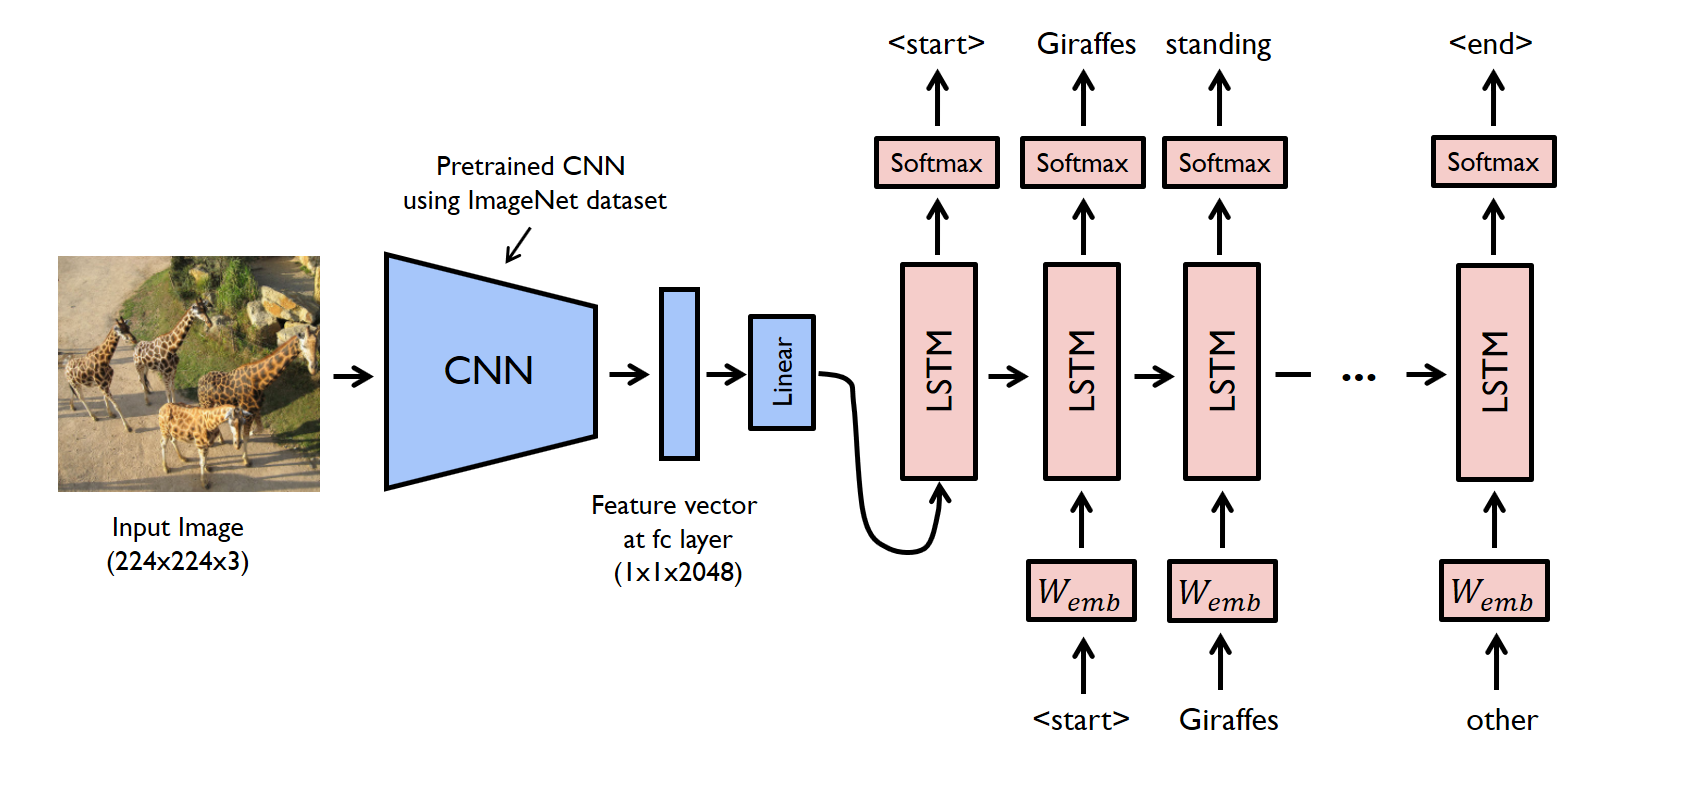

In [64]:
from IPython.display import Image
Image("imgs/image_captioning.png")

In [148]:
vocab_size = len(vocab.keys())

In [176]:
embed_size = 100
hidden_size = 50
embed = nn.Embedding(vocab_size, embed_size)
gru = nn.GRU(embed_size, hidden_size, 1, batch_first=True)
linear = nn.Linear(hidden_size, vocab_size)

In [177]:
images, captions, lengths = next(iter(trn_dl))

In [178]:
embeddings = embed(captions.long())
embeddings.shape

torch.Size([2, 20, 100])

In [179]:
features = encoder_model(images)
features.unsqueeze(1).shape

torch.Size([2, 1, 100])

In [180]:
embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
embeddings.shape

torch.Size([2, 21, 100])

In [181]:
packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 

In [182]:
outputs, _ = gru(packed)

In [185]:
outputs.data.shape

torch.Size([32, 50])

In [184]:
# note that outputs.data.shape is sum(lengths) x hidden_size
lengths

[20, 12]

In [199]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        outputs, hidden = self.gru(packed)
        outputs = self.linear(outputs.data)
        return outputs
    
    def sample(self, features, hidden=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            output, hidden = self.gru(inputs, hidden)          # hiddens: (batch_size, 1, hidden_size)
            out = self.linear(output.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = out.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## Training 

In [202]:
embed_size = 100
hidden_size = 512
num_layers = 1
batch_size = 250

In [203]:
encoder = EncoderCNN(embed_size).cuda()
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).cuda()
    
# Loss and optimizer
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [204]:
trn_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [205]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [206]:
from tqdm import tnrange, tqdm_notebook

In [207]:
def train(trn_dl, num_epochs=10):
    for epoch in range(num_epochs):
        total_loss = 0
        total = 0
        for images, captions, lengths in tqdm_notebook(trn_dl):
            
            # Set mini-batch dataset
            batch_size = images.size(0)
            images = images.cuda()
            captions = captions.cuda()
            targets = pack_padded_sequence(captions, lengths, batch_first=True).data
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = F.cross_entropy(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*batch_size 
            total += batch_size
        save_model(encoder, PATH/"encoder-tmp.pth")
        save_model(decoder, PATH/"decoder-tmp.pth")
        print(total_loss/total)

In [ ]:
train(trn_dl, num_epochs=1)

In [ ]:
train(trn_dl, num_epochs=10)

In [92]:
train(trn_dl, num_epochs=10)

0.04012074929995369
0.03389141124968366
0.032083471820974256
0.030932809662631854
0.030069673587850024
0.029389275441552013
0.028831501933699544
0.02836147714309412
0.027968059476768264
0.027629494414018508


In [ ]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [ ]:
save_model(encoder, PATH/"encoder-10.pth")
save_model(decoder, PATH/"decoder-10.pth")

In [ ]:
train(trn_dl, num_epochs=3)

In [ ]:
save_model(encoder, PATH/"encoder-13.pth")
save_model(decoder, PATH/"decoder-13.pth")

In [100]:
train(trn_dl, num_epochs=3)

0.026666308888500957
0.026493903817471923
0.02634520070580513


In [101]:
save_model(encoder, PATH/"encoder-16.pth")
save_model(decoder, PATH/"decoder-16.pth")

In [102]:
train(trn_dl, num_epochs=5)

0.026201303680847107
0.026081715852799916
0.02597795610450448
0.025884864431983495
0.025787605284016357


In [103]:
save_model(encoder, PATH/"encoder-21.pth")
save_model(decoder, PATH/"decoder-21.pth")

In [104]:
train(trn_dl, num_epochs=9)

0.025714092272567
0.025638320510306525
0.025579333224756248
0.025516161910280492
0.02546659523215611
0.02542221685356583
0.025374075389019677
0.02533917329643183
0.025305386393472767


In [105]:
save_model(encoder, PATH/"encoder-30.pth")
save_model(decoder, PATH/"decoder-30.pth")

In [106]:
train(trn_dl, num_epochs=10)

0.025268142891778575
0.025243027436446904
0.025208707103201
0.025182242739658963
0.02517916999055849
0.025158080210478478
0.02514127761314333
0.02512751810486432
0.025113312479684027
0.025094203915086957


In [107]:
save_model(encoder, PATH/"encoder-40.pth")
save_model(decoder, PATH/"decoder-40.pth")

## Evaluation

In [118]:
def validation(val_dl, encoder, decoder):
    total_step = len(valid_ds)
    total_loss = 0
    for i, (images, captions, lengths) in enumerate(val_dl):
        images = images.cuda()
        captions = captions.cuda()
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    print(total_loss/total_step)

In [109]:
load_model(encoder, PATH/"encoder-40.pth")

In [110]:
load_model(decoder, PATH/"decoder-40.pth")

In [117]:
val_dl = DataLoader(valid_ds, batch_size=100, shuffle=False, collate_fn=collate_fn)

In [187]:
validation(val_dl, encoder, decoder)

0.25585410760106353


### Generating captions from images

In [159]:
val_dl = DataLoader(valid_ds, batch_size=10, shuffle=True, collate_fn=collate_fn)

In [160]:
images, captions, lengths = next(iter(val_dl))

In [174]:
def clean_sentence(sentence_indices, words):
    sentence = []
    for i in sentence_indices:
        word = words[i]
        sentence.append(word)
        if word == "<end>":
            break
    return " ".join(sentence)

In [178]:
def denormalize(im, stats=imagenet_stats):
    """Normalizes images with Imagenet stats."""
    return im*stats[1] + stats[0]

def denorm(x):
    x = x.numpy()
    x = x.transpose(1,2,0)
    x = denormalize(x)
    return np.clip(x, 0 , 1)

In [185]:
def look_at_results(val_dl, words):
    images, captions, lengths = next(iter(val_dl))
    features = encoder(images.cuda())
    pred_sentence = decoder.sample(features)
    for i in range(images.shape[0]):
        pred = clean_sentence(pred_sentence[i], words) 
        actual = clean_sentence(captions[i].numpy(), words)
        print("Predicted:", pred)
        print("Actual:", actual, "\n")
        im = denorm(images[i])
        plt.imshow(im)
        plt.show()

Predicted: <start> a cat sitting on a red suitcase on a table <end>
Actual: <start> a close up of a cat in a cat bed with a teddy bear <end> 



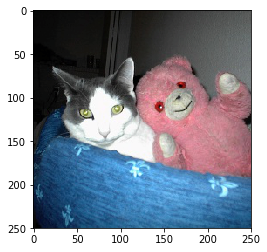

Predicted: <start> a man and a woman sitting at a table with a cake . <end>
Actual: <start> a boy getting ready to blow out candles on a birthday cake . <end> 



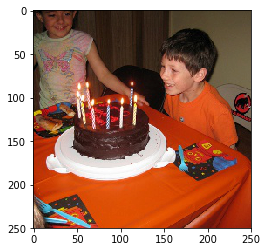

Predicted: <start> a man in a suit and tie with a hat on . <end>
Actual: <start> a person that is wearing glasses and a suit and tie . <end> 



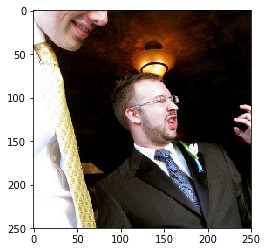

Predicted: <start> a kitchen with a lot of food on the counter <end>
Actual: <start> a kitchen with a large stove and a lot of pots . <end> 



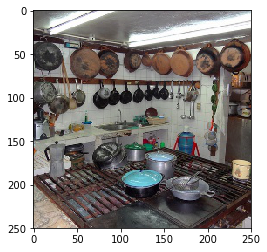

Predicted: <start> a herd of elephants walking across a grass covered field . <end>
Actual: <start> an elephant and two baby elephants on the grassy field . <end> 



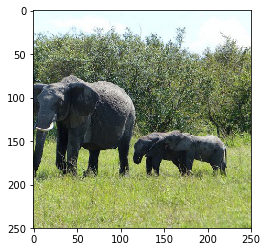

Predicted: <start> a baby sitting on the floor in a bath room with a toilet and a sink . <end>
Actual: <start> a toddler is brushing his teeth in a bathroom . <end> 



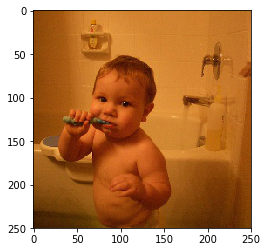

Predicted: <start> a person riding a skate board on a hand rail <end>
Actual: <start> a surfing simulator is being used by fellow surfers . <end> 



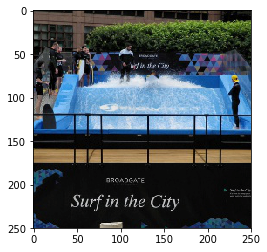

Predicted: <start> a street sign on a bicycle rack on a street <end>
Actual: <start> a group of bicycles are parked under a clock <end> 



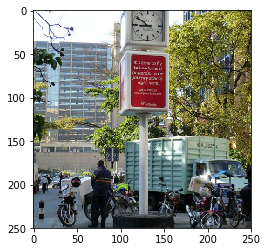

Predicted: <start> a man with a beard is wearing a shirt and tie . <end>
Actual: <start> a man smiling while talking on his phone <end> 



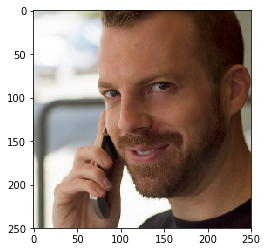

Predicted: <start> a large airplane that is sitting on a runway . <end>
Actual: <start> an airplane nose sits in a hangar . <end> 



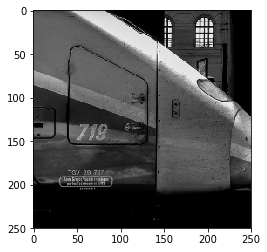

In [186]:
look_at_results(val_dl, words)

In [128]:
images[0].transpose

torch.Size([3, 250, 250])

## References
* https://github.com/karpathy/neuraltalk2/blob/master/coco/coco_preprocess.ipynb
* https://github.com/ntrang086/image_captioning
* https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning